In [2]:
## Logging into Hugging face hub

from huggingface_hub import notebook_login

notebook_login()

In [3]:
import os, random
# os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, DatasetDict

import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoImageProcessor, AutoModelForImageClassification
from transformers import EarlyStoppingCallback 

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import torch

import evaluate

In [4]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
from datasets import load_dataset

In [10]:
# dataset = load_dataset("imagefolder", data_dir="data/Augmented_Splitted/")
# dataset = dataset.shuffle(seed=SEED)
# dataset.push_to_hub("pcam-augmented-train-test-val-50k")

In [7]:
# loading the data from hugging face which was already pushed.

dataset = load_dataset('anurag2op/pcam-augmented-train-test-val-50k')

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
dataset = dataset.shuffle(seed=42)

In [10]:
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

In [19]:
MODEL_CKPT='google/vit-large-patch16-224-in21k'

NUM_OF_EPOCHS = 5

LEARNING_RATE=2e-4

STEPS=100

BATCH_SIZE = 16

In [12]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['non_tumor', 'tumor'], id=None)}

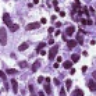

In [13]:
example = dataset["train"][2222]
example['image'] 

In [14]:
example['label']

1

#### Metrics - Accuracy, Precision, Recall & f1 score

In [15]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

In [16]:
# creating id2label and label2id to decode the numbers back to string for convenience

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [17]:
id2label[0] , id2label[1] 

('non_tumor', 'tumor')

In [20]:
image_processor  = AutoImageProcessor.from_pretrained(MODEL_CKPT)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

C:\Users\DSAI\anaconda3\envs\tf\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DSAI\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

In [21]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [22]:
from torchvision.transforms import (
    Normalize,
    Compose,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    
transforms = Compose(
        [
            Resize(image_processor.size['height']),
            ToTensor(),
            normalize
        ]
    )

def preprocess(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    
    return example_batch


In [23]:
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)

In [24]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 1,
 'pixel_values': tensor([[[-0.3333, -0.3569, -0.4353,  ...,  0.1294,  0.1294,  0.1294],
          [-0.3333, -0.3569, -0.4353,  ...,  0.1294,  0.1294,  0.1294],
          [-0.3333, -0.3569, -0.4353,  ...,  0.1294,  0.1294,  0.1294],
          ...,
          [ 0.3490,  0.3020,  0.1843,  ...,  0.0980,  0.0980,  0.0980],
          [ 0.2392,  0.1686, -0.0588,  ...,  0.1843,  0.1843,  0.1843],
          [ 0.2078,  0.1216, -0.1451,  ...,  0.2157,  0.2157,  0.2157]],
 
         [[-0.6549, -0.6784, -0.7569,  ..., -0.1686, -0.1686, -0.1686],
          [-0.6549, -0.6784, -0.7569,  ..., -0.1686, -0.1686, -0.1686],
          [-0.6549, -0.6784, -0.7569,  ..., -0.1686, -0.1686, -0.1686],
          ...,
          [ 0.0510,  0.0118, -0.1059,  ..., -0.2078, -0.2078, -0.2078],
          [-0.1059, -0.1765, -0.3961,  ..., -0.1294, -0.1294, -0.1294],
          [-0.1529, -0.2392, -0.4902,  ..., -0.0980, -0.0980, -0.0980]],
 


In [25]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to(device)

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model_name = MODEL_CKPT.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-pcam-finetuned",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs'
)

In [28]:
# creating a function to put together a list of samples into a mini training batch.

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [29]:
## callback for early stoppping

early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

In [30]:
# initiate the Trainer

trainer = Trainer(
    model,
    args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer = image_processor,
    compute_metrics = compute_metrics,
    data_collator = collate_fn,
    callbacks=[early_stopping]
    
)

In [31]:
# train the model

train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
1,0.454900,0.385383,0.830500,0.830469,0.830500,0.830469,0.830500,0.830500,0.830500,0.830741,0.830500,0.830741
2,0.334300,0.407916,0.826200,0.824380,0.826200,0.824380,0.826200,0.826200,0.826200,0.840307,0.826200,0.840307
3,0.281500,0.323113,0.857400,0.857400,0.857400,0.857400,0.857400,0.857400,0.857400,0.857403,0.857400,0.857403
4,0.302900,0.330067,0.862800,0.862390,0.862800,0.862390,0.862800,0.862800,0.862800,0.867178,0.862800,0.867178
5,0.286700,0.317541,0.875900,0.875896,0.875900,0.875896,0.875900,0.875900,0.875900,0.875952,0.875900,0.875952


In [32]:
#saving the model in local drive

trainer.save_model()

In [33]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =           5.0
  total_flos               = 38268162849GF
  train_loss               =        0.3454
  train_runtime            =    3:11:35.54
  train_samples_per_second =        13.049
  train_steps_per_second   =         0.816


In [34]:
trainer.save_state()

In [35]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_Macro F1           =     0.8673
  eval_Macro Precision    =     0.8673
  eval_Macro Recall       =     0.8673
  eval_Micro F1           =     0.8673
  eval_Micro Precision    =     0.8673
  eval_Micro Recall       =     0.8673
  eval_Weighted F1        =     0.8673
  eval_Weighted Precision =     0.8673
  eval_Weighted Recall    =     0.8673
  eval_accuracy           =     0.8673
  eval_loss               =      0.336
  eval_runtime            = 0:04:01.56
  eval_samples_per_second =     41.397
  eval_steps_per_second   =      2.587


In [36]:
predictions = trainer.predict(test_ds)

In [37]:
predictions[0]

array([[ 3.9647353 , -3.8196454 ],
       [ 4.533644  , -4.4138346 ],
       [ 0.9096314 , -0.7320923 ],
       ...,
       [ 0.9467531 , -0.79800093],
       [ 2.820075  , -2.7671976 ],
       [-1.2294534 ,  1.2261052 ]], dtype=float32)

In [38]:
y_pred = np.argmax(predictions[0],axis=1)

In [39]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [40]:
y_pred.shape

(10000,)

In [41]:
y_test = []

for i,j in enumerate(test_ds):
    y_test.append(test_ds[i]['label'])

In [42]:
y_test = np.array(y_test)

In [43]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [44]:
y_test.shape

(10000,)

In [45]:
print(confusion_matrix(y_test,y_pred))

[[4342  658]
 [ 669 4331]]


In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [47]:
target_classes=[]

label_map = { 0 :'non_tumor', 1:"tumor"}


for i in label_map.values():
    target_classes.append(i) 

In [48]:
target_classes

['non_tumor', 'tumor']

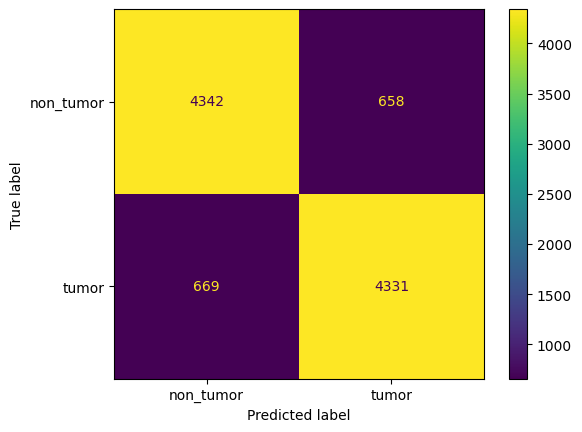

In [50]:

ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred), display_labels=target_classes)
ax.plot()
plt.savefig('ViT.png',format= 'png')
plt.show()

In [51]:
repo_name = "vit-large-patch16-224-in21k-finetuned-pcam"

model.push_to_hub(repo_name)
image_processor.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anurag2op/vit-large-patch16-224-in21k-finetuned-pcam/commit/c9afe5cf0474b45d6768a5f593f09a67e19e43fd', commit_message='Upload processor', commit_description='', oid='c9afe5cf0474b45d6768a5f593f09a67e19e43fd', pr_url=None, pr_revision=None, pr_num=None)